## About dataset

#### https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
Dataset contains 7022 images of human brain MRI images which are classified into 4 classes: 
1. glioma 
2. meningioma
3. pituitary
4. no tumor


### 1. Data analysis

In [1]:
import os, os.path
import matplotlib.pyplot as plt

Let's count how many images are in train/test directories

In [2]:
train_dir = "Training"
test_dir = "Testing"

In [3]:
def countClasses(directory):
    counts = {}
    for path in os.listdir(directory):
        dirPath = os.path.join(directory, path)
        if os.path.isdir(dirPath):
            counts[path] = len([name for name in os.listdir(dirPath) 
                                if os.path.isfile(os.path.join(dirPath, name))])
        
    return counts

In [4]:
train_counts = countClasses(train_dir)
print(train_counts)

{'pituitary': 1457, 'notumor': 1595, 'glioma': 1321, 'meningioma': 1339}


<BarContainer object of 4 artists>

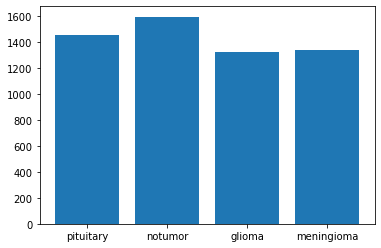

In [5]:
plt.bar(train_counts.keys(), train_counts.values())

In [6]:
test_counts = countClasses(test_dir)
print(test_counts)

{'pituitary': 300, 'notumor': 405, 'glioma': 300, 'meningioma': 306}


<BarContainer object of 4 artists>

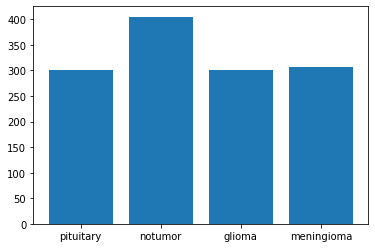

In [7]:
plt.bar(test_counts.keys(), test_counts.values())

In [8]:
train_count = sum(train_counts.values())
test_count = sum(test_counts.values())
print("Training data: ",train_count)
print("Testing data: ", test_count)

Training data:  5712
Testing data:  1311


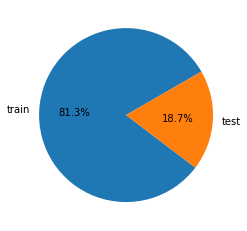

In [9]:
plt.pie([train_count, test_count], 
        labels = ["train", "test"],
        startangle = 30,
        autopct='%.1f%%')

plt.show()

### 2. Data preprocessing 

In [10]:
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow import keras

batch_size = 32
img_height = 180
img_width = 180

Let's use 10% of training data as validation set.
Each image is going to be resized to 180x180 pixels

In [11]:
train_ds = image_dataset_from_directory(
  "Training/",
  validation_split=0.1,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5712 files belonging to 4 classes.
Using 5141 files for training.
Metal device set to: Apple M1


2022-05-29 21:44:03.908239: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-29 21:44:03.908369: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [12]:
val_ds = image_dataset_from_directory(
  "Training/",
  validation_split=0.1,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5712 files belonging to 4 classes.
Using 571 files for validation.


As expected in single batch there are 32 images of 180x180 size

In [13]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


2022-05-29 21:44:06.322091: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [14]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import *

The RGB values are in range of [0,255]. Let's rescale that to [0,1] range

In [22]:
resize_and_rescale = tf.keras.Sequential([
  Resizing(img_height, img_width, input_shape=(img_height, img_width, 3)),
  Rescaling(1./255)
])

We're going to save only the best model.
To avoid overfitting, training is ended if validation accuracy is not improving in 10 epochs 

In [23]:
from keras import callbacks

TRAINED_MODEL_DIR = "trained_models/"

model_name = TRAINED_MODEL_DIR + "model-{val_accuracy:.4f}.hdf5"

if not os.path.exists(TRAINED_MODEL_DIR):
    os.makedirs(TRAINED_MODEL_DIR)

In [24]:
def create_callbacks():
    return [
        callbacks.EarlyStopping(monitor="val_accuracy", patience=10, verbose=1),

        callbacks.ModelCheckpoint(model_name, monitor="val_accuracy", 
                                  verbose=1, save_best_only=True),
    ]

In [25]:
_callbacks = create_callbacks()

### 3. Creating and training models

First, let's create simple network with one Dense layer

In [27]:
import numpy as np
from keras import Sequential
from keras import optimizers

num_classes = 4

modelFlatten = Sequential([
    resize_and_rescale,
    Flatten(),
    Dense(num_classes),
    Activation("softmax")
])

modelFlatten.compile(
  optimizer='adam',
  loss="SparseCategoricalCrossentropy",
  metrics=['accuracy'])

In [28]:
modelFlatten.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 flatten_2 (Flatten)         (None, 97200)             0         
                                                                 
 dense_2 (Dense)             (None, 4)                 388804    
                                                                 
 activation_2 (Activation)   (None, 4)                 0         
                                                                 
Total params: 388,804
Trainable params: 388,804
Non-trainable params: 0
_________________________________________________________________


In [29]:
from keras.callbacks import History

history = modelFlatten.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=_callbacks,
    shuffle=True
)

Epoch 1/10
  1/161 [..............................] - ETA: 42s - loss: 1.3747 - accuracy: 0.3125

2022-05-29 21:45:06.387955: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


161/161 [==============================] - ETA: 0s - loss: 2.2424 - accuracy: 0.6174

2022-05-29 21:45:08.703507: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_accuracy improved from -inf to 0.70753, saving model to trained_models/model-0.7075.hdf5
161/161 [==============================] - 3s 16ms/step - loss: 2.2424 - accuracy: 0.6174 - val_loss: 1.2206 - val_accuracy: 0.7075
Epoch 2/10
160/161 [============================>.] - ETA: 0s - loss: 0.9865 - accuracy: 0.7393
Epoch 00002: val_accuracy improved from 0.70753 to 0.76708, saving model to trained_models/model-0.7671.hdf5
161/161 [==============================] - 3s 15ms/step - loss: 0.9856 - accuracy: 0.7392 - val_loss: 0.9788 - val_accuracy: 0.7671
Epoch 3/10
160/161 [============================>.] - ETA: 0s - loss: 0.7514 - accuracy: 0.7883
Epoch 00003: val_accuracy improved from 0.76708 to 0.78109, saving model to trained_models/model-0.7811.hdf5
161/161 [==============================] - 3s 15ms/step - loss: 0.7496 - accuracy: 0.7886 - val_loss: 1.1444 - val_accuracy: 0.7811
Epoch 4/10
160/161 [============================>.] - ETA: 0s - loss: 0.8518 - accuracy

ModelFlatten best val_acc = 0.8424

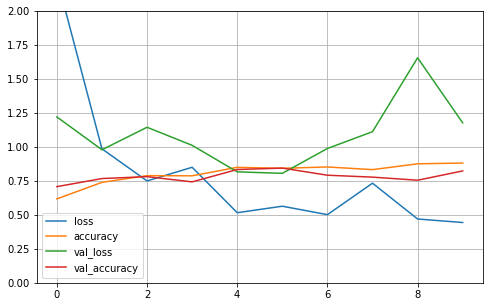

In [32]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 2)
plt.show()

#### Deep neural networks

In [33]:
modelFlattenBatchNormalization = Sequential([
    resize_and_rescale,
    Flatten(),
    BatchNormalization(),
    Activation("relu"),
    Dropout(0.3),
    
    Dense(300, activation="relu"),
    BatchNormalization(),
    Activation("relu"),
    Dropout(0.3),
    
    Dense(100, activation="relu"),
    BatchNormalization(),
    Activation("relu"),
    Dropout(0.3),
    
    Dense(num_classes),
    Activation("softmax")
])

In [34]:
modelFlattenBatchNormalization.compile(
  optimizer='adam',
  loss="SparseCategoricalCrossentropy",
  metrics=['accuracy'])

In [36]:
modelFlattenBatchNormalization.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 flatten_3 (Flatten)         (None, 97200)             0         
                                                                 
 batch_normalization (BatchN  (None, 97200)            388800    
 ormalization)                                                   
                                                                 
 activation_3 (Activation)   (None, 97200)             0         
                                                                 
 dropout (Dropout)           (None, 97200)             0         
                                                                 
 dense_3 (Dense)             (None, 300)               29160300  
                                                      

In [37]:
history = modelFlattenBatchNormalization.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=_callbacks,
    shuffle=True
)

Epoch 1/10


2022-05-29 21:47:14.150601: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


161/161 [==============================] - ETA: 0s - loss: 0.8793 - accuracy: 0.6802

2022-05-29 21:47:27.029952: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_accuracy did not improve from 0.84413
161/161 [==============================] - 14s 83ms/step - loss: 0.8793 - accuracy: 0.6802 - val_loss: 1.0416 - val_accuracy: 0.6287
Epoch 2/10
161/161 [==============================] - ETA: 0s - loss: 0.5723 - accuracy: 0.7981
Epoch 00002: val_accuracy did not improve from 0.84413
161/161 [==============================] - 13s 82ms/step - loss: 0.5723 - accuracy: 0.7981 - val_loss: 0.7014 - val_accuracy: 0.7811
Epoch 3/10
161/161 [==============================] - ETA: 0s - loss: 0.4672 - accuracy: 0.8308
Epoch 00003: val_accuracy did not improve from 0.84413
161/161 [==============================] - 13s 82ms/step - loss: 0.4672 - accuracy: 0.8308 - val_loss: 0.5384 - val_accuracy: 0.7881
Epoch 4/10
161/161 [==============================] - ETA: 0s - loss: 0.3988 - accuracy: 0.8605
Epoch 00004: val_accuracy improved from 0.84413 to 0.88616, saving model to trained_models/model-0.8862.hdf5
161/161 [=============================

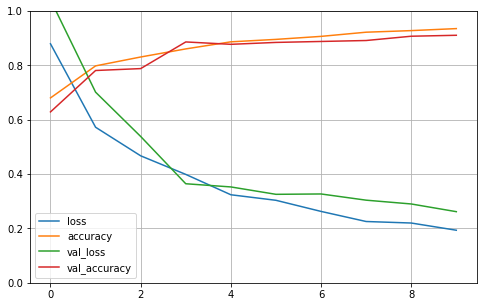

In [38]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

#### Convolutional neural networks

In [39]:
modelConv1 = Sequential([
    resize_and_rescale,
    Conv2D(32, (3,3), padding="same", activation="relu"),
    Conv2D(32, 3, padding="same", activation="relu"),
    MaxPooling2D(2),
    
    Conv2D(64, 3, padding="same", activation="relu"),
    Conv2D(64, 3, padding="same", activation="relu"),
    MaxPooling2D(2),
    
    Conv2D(128, 3, padding="same", activation="relu"),
    Conv2D(256, 3, padding="same", activation="relu"),
    GlobalAveragePooling2D(),
    Dense(num_classes),
    Activation("softmax")
])

In [40]:
modelConv1.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 90, 90, 64)        36928     
                                                      

In [41]:
modelConv1.compile(
  optimizer='adam',
  loss="SparseCategoricalCrossentropy",  
  metrics=['accuracy'])

In [155]:
history2 = modelConv1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=_callbacks,
    shuffle=True
)

Epoch 1/5
161/161 [==============================] - ETA: 0s - loss: 0.6697 - accuracy: 0.7397
Epoch 00001: val_accuracy did not improve from 0.86165
161/161 [==============================] - 50s 309ms/step - loss: 0.6697 - accuracy: 0.7397 - val_loss: 0.6571 - val_accuracy: 0.7496
Epoch 2/5
161/161 [==============================] - ETA: 0s - loss: 0.6478 - accuracy: 0.7495
Epoch 00002: val_accuracy did not improve from 0.86165
161/161 [==============================] - 50s 310ms/step - loss: 0.6478 - accuracy: 0.7495 - val_loss: 0.6113 - val_accuracy: 0.7723
Epoch 3/5
161/161 [==============================] - ETA: 0s - loss: 0.5997 - accuracy: 0.7674
Epoch 00003: val_accuracy did not improve from 0.86165
161/161 [==============================] - 50s 310ms/step - loss: 0.5997 - accuracy: 0.7674 - val_loss: 0.6177 - val_accuracy: 0.7758
Epoch 4/5
161/161 [==============================] - ETA: 0s - loss: 0.5516 - accuracy: 0.7870
Epoch 00004: val_accuracy did not improve from 0.8616

In [48]:
modelConv2 = Sequential([
    resize_and_rescale,
    Conv2D(32, (3,3), padding="same", activation="relu"),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D((2,2)),
    Dropout(0.2),
    
    Conv2D(32, 3, padding="same", activation="relu"),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D((2,2)),
    Dropout(0.2),
    
    Conv2D(64, 3, padding="same", activation="relu"),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D((2,2)),
    Dropout(0.2),
    
    Conv2D(64, 3, padding="same", activation="relu"),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D((2,2)),
    Dropout(0.2),
    
    Conv2D(128, 3, padding="same", activation="relu"),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D((2,2)),
    Dropout(0.2),
    
    Conv2D(256, 3, padding="same", activation="relu"),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D((2,2)),
    Dropout(0.2),
    
    Flatten(),
    Dense(num_classes),
    Activation("softmax")
])

modelConv2.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 batch_normalization_13 (Bat  (None, 180, 180, 32)     128       
 chNormalization)                                                
                                                                 
 activation_20 (Activation)  (None, 180, 180, 32)      0         
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 90, 90, 32)       0         
 g2D)                                                            
                                                                 
 dropout_13 (Dropout)        (None, 90, 90, 32)       

In [49]:
modelConv2.compile(
  optimizer='adam',
  loss="SparseCategoricalCrossentropy",  
  metrics=['accuracy'])

In [50]:
history3 = modelConv2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=_callbacks,
    shuffle=True
)

Epoch 1/20


2022-05-29 22:26:12.262620: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


161/161 [==============================] - ETA: 0s - loss: 0.9018 - accuracy: 0.6917

2022-05-29 22:26:39.936988: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_accuracy did not improve from 0.91068
161/161 [==============================] - 29s 174ms/step - loss: 0.9018 - accuracy: 0.6917 - val_loss: 1.3870 - val_accuracy: 0.2434
Epoch 2/20
161/161 [==============================] - ETA: 0s - loss: 0.5294 - accuracy: 0.8059
Epoch 00002: val_accuracy did not improve from 0.91068
161/161 [==============================] - 27s 167ms/step - loss: 0.5294 - accuracy: 0.8059 - val_loss: 1.3033 - val_accuracy: 0.4273
Epoch 3/20
161/161 [==============================] - ETA: 0s - loss: 0.4064 - accuracy: 0.8471
Epoch 00003: val_accuracy did not improve from 0.91068
161/161 [==============================] - 27s 167ms/step - loss: 0.4064 - accuracy: 0.8471 - val_loss: 1.1971 - val_accuracy: 0.4081
Epoch 4/20
161/161 [==============================] - ETA: 0s - loss: 0.3459 - accuracy: 0.8693
Epoch 00004: val_accuracy did not improve from 0.91068
161/161 [==============================] - 27s 170ms/step - loss: 0.3459 - accuracy: 0.86

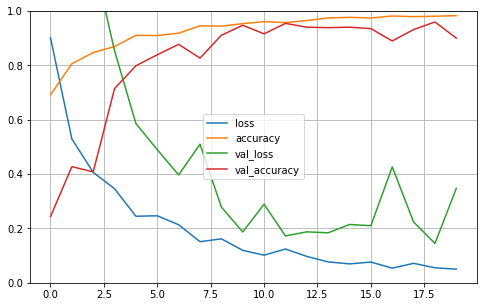

In [56]:
pd.DataFrame(history3.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

#### VGG16

In [204]:
from keras.applications.vgg16 import VGG16

_VGG16 = VGG16(weights='imagenet',
                   include_top=False,
                   input_shape=(img_height,img_width,3))

modelVGG16_1 = Sequential([
    _VGG16,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(num_classes),
    Activation("softmax")
])

modelVGG16_1.layers[0].trainable = False

modelVGG16_1.summary()

Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 flatten_33 (Flatten)        (None, 12800)             0         
                                                                 
 dense_61 (Dense)            (None, 256)               3277056   
                                                                 
 dense_62 (Dense)            (None, 4)                 1028      
                                                                 
 activation_56 (Activation)  (None, 4)                 0         
                                                                 
Total params: 17,992,772
Trainable params: 3,278,084
Non-trainable params: 14,714,688
_________________________________________________________________


In [206]:
modelVGG16_1.compile(
  optimizer='adam',
  loss="SparseCategoricalCrossentropy",  
  metrics=['accuracy'])

history3 = modelVGG16_1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=_callbacks,
    shuffle=True
)

Epoch 1/5


/Users/jakubstepien/miniforge3/envs/env_tf/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)
2022-05-27 08:33:54.523357: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


161/161 [==============================] - ETA: 0s - loss: 2.1112 - accuracy: 0.8461

2022-05-27 08:34:56.150259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_accuracy did not improve from 0.90718
161/161 [==============================] - 69s 425ms/step - loss: 2.1112 - accuracy: 0.8461 - val_loss: 0.2782 - val_accuracy: 0.8984
Epoch 2/5
161/161 [==============================] - ETA: 0s - loss: 0.1549 - accuracy: 0.9516
Epoch 00002: val_accuracy improved from 0.90718 to 0.92294, saving model to trained_models/model-0.9229.hdf5
161/161 [==============================] - 69s 431ms/step - loss: 0.1549 - accuracy: 0.9516 - val_loss: 0.3308 - val_accuracy: 0.9229
Epoch 3/5
161/161 [==============================] - ETA: 0s - loss: 0.0640 - accuracy: 0.9815
Epoch 00003: val_accuracy improved from 0.92294 to 0.93520, saving model to trained_models/model-0.9352.hdf5
161/161 [==============================] - 72s 448ms/step - loss: 0.0640 - accuracy: 0.9815 - val_loss: 0.3232 - val_accuracy: 0.9352
Epoch 4/5
161/161 [==============================] - ETA: 0s - loss: 0.0376 - accuracy: 0.9870
Epoch 00004: val_accuracy improved from

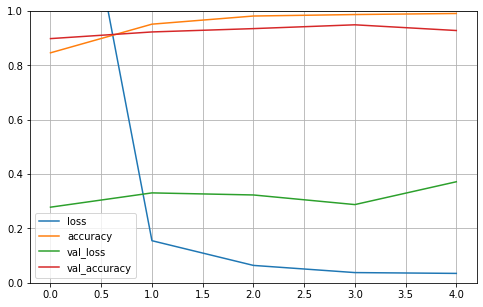

In [207]:
pd.DataFrame(history3.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

## Model evaluation

Let's evaluate all saved models on test set

In [51]:
test_ds = image_dataset_from_directory(
  "Testing/",
  image_size=(img_height, img_width))

Found 1311 files belonging to 4 classes.


In [52]:
trained_models = {}

for filename in os.listdir(TRAINED_MODEL_DIR):
    f = os.path.join(TRAINED_MODEL_DIR, filename)
    if "hdf5" in f:
        trained_models[filename] = f

In [53]:
trained_models = {k: v for k, v in sorted(trained_models.items(), key=lambda item: item[1])}
trained_models

{'model-0.7075.hdf5': 'trained_models/model-0.7075.hdf5',
 'model-0.7356.hdf5': 'trained_models/model-0.7356.hdf5',
 'model-0.7671.hdf5': 'trained_models/model-0.7671.hdf5',
 'model-0.7811.hdf5': 'trained_models/model-0.7811.hdf5',
 'model-0.8336.hdf5': 'trained_models/model-0.8336.hdf5',
 'model-0.8424.hdf5': 'trained_models/model-0.8424.hdf5',
 'model-0.8441.hdf5': 'trained_models/model-0.8441.hdf5',
 'model-0.8476.hdf5': 'trained_models/model-0.8476.hdf5',
 'model-0.8616.hdf5': 'trained_models/model-0.8616.hdf5',
 'model-0.8862.hdf5': 'trained_models/model-0.8862.hdf5',
 'model-0.8879.hdf5': 'trained_models/model-0.8879.hdf5',
 'model-0.8897.hdf5': 'trained_models/model-0.8897.hdf5',
 'model-0.8914.hdf5': 'trained_models/model-0.8914.hdf5',
 'model-0.9037.hdf5': 'trained_models/model-0.9037.hdf5',
 'model-0.9072.hdf5': 'trained_models/model-0.9072.hdf5',
 'model-0.9107.hdf5': 'trained_models/model-0.9107.hdf5',
 'model-0.9229.hdf5': 'trained_models/model-0.9229.hdf5',
 'model-0.9352

In [60]:
tmp2 = keras.models.load_model('trained_models/model-0.8441.hdf5')

In [55]:
tmp = keras.models.load_model('trained_models/model-0.9492.hdf5')
tmp.evaluate(test_ds)

/Users/jakubstepien/miniforge3/envs/env_tf/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)
2022-05-29 22:38:06.273181: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 16s 374ms/step - loss: 0.2013 - accuracy: 0.9504


[0.20134738087654114, 0.950419545173645]

In [225]:
for name, path in trained_models.items():
    print("------------")
    print(name)
    model = keras.models.load_model(path)
    model.evaluate(test_ds)

------------
model-0.7356.hdf5
 4/41 [=>............................] - ETA: 0s - loss: 1.0656 - accuracy: 0.7812

2022-05-27 09:24:12.761226: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 1s 14ms/step - loss: 1.2988 - accuracy: 0.7033
------------
model-0.8424.hdf5
 4/41 [=>............................] - ETA: 0s - loss: 0.5831 - accuracy: 0.8203

2022-05-27 09:24:13.467200: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 1s 13ms/step - loss: 0.9080 - accuracy: 0.8009
------------
model-0.8476.hdf5
 5/41 [==>...........................] - ETA: 0s - loss: 0.5829 - accuracy: 0.8750

2022-05-27 09:24:14.157654: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 1s 13ms/step - loss: 0.9925 - accuracy: 0.8413
------------
model-0.8616.hdf5
 5/41 [==>...........................] - ETA: 0s - loss: 0.9221 - accuracy: 0.8688

2022-05-27 09:24:14.846293: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 1s 13ms/step - loss: 0.9580 - accuracy: 0.8543
------------
model-0.8897.hdf5
 1/41 [..............................] - ETA: 7s - loss: 0.3806 - accuracy: 0.8125

2022-05-27 09:24:15.801546: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 2s 36ms/step - loss: 0.3789 - accuracy: 0.8711
------------
model-0.9037.hdf5
 1/41 [..............................] - ETA: 8s - loss: 0.4419 - accuracy: 0.8750

2022-05-27 09:24:17.785039: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 2s 36ms/step - loss: 0.3544 - accuracy: 0.8886
------------
model-0.9072.hdf5
 1/41 [..............................] - ETA: 8s - loss: 0.3000 - accuracy: 0.9375

2022-05-27 09:24:19.824061: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 2s 36ms/step - loss: 0.2987 - accuracy: 0.9115
------------
model-0.9229.hdf5


2022-05-27 09:24:21.647315: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 17s 403ms/step - loss: 0.2069 - accuracy: 0.9291
------------
model-0.9352.hdf5


2022-05-27 09:24:38.570806: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 17s 402ms/step - loss: 0.1909 - accuracy: 0.9428
------------
model-0.9492.hdf5


2022-05-27 09:24:55.971715: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 16s 377ms/step - loss: 0.2013 - accuracy: 0.9504


### Conversion to CoreML format

In [57]:
import coremltools

/Users/jakubstepien/miniforge3/envs/env_tf/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [58]:
labels = [
    "glioma",
    "meningioma",
    "notumor",
    "pituitary"
]

In [64]:
from keras.layers.normalization.layer_normalization import *
from keras.layers.normalization.batch_normalization import *

In [71]:
coreml_model = coremltools.convert(tmp)
# coreml_model = coremltools.converters.keras.convert(tmp2,
#                                                     input_names="image",
#                                                     image_input_names="image",
#                                                     image_scale=1/255.0,
#                                                     class_labels=labels)

2022-05-29 23:04:23.894519: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2022-05-29 23:04:23.894602: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2022-05-29 23:04:23.894756: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-29 23:04:23.894774: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-05-29 23:04:23.895702: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:1149] Optimization results for grappler item: graph_to_optimize
  function_optimizer: funct

In [73]:
print(coreml_model)

input {
  name: "vgg16_input"
  type {
    multiArrayType {
      shape: 1
      shape: 180
      shape: 180
      shape: 3
      dataType: FLOAT32
      shapeRange {
        sizeRanges {
          lowerBound: 1
          upperBound: -1
        }
        sizeRanges {
          lowerBound: 180
          upperBound: 180
        }
        sizeRanges {
          lowerBound: 180
          upperBound: 180
        }
        sizeRanges {
          lowerBound: 3
          upperBound: 3
        }
      }
    }
  }
}
output {
  name: "Identity"
  type {
    multiArrayType {
      dataType: FLOAT32
    }
  }
}
metadata {
  userDefined {
    key: "com.github.apple.coremltools.source"
    value: "tensorflow==2.7.0"
  }
  userDefined {
    key: "com.github.apple.coremltools.version"
    value: "5.2.0"
  }
}



In [72]:
coreml_model.save("TumorClassifier.mlmodel")

In [69]:
# coreml_model = coremltools.converters.keras.convert(
#     tmp2,
#     input_names="image",
#     image_input_names="image",
#     output_names="labelProbability",
#     predicted_feature_name="label",
#     red_bias=-1,
#     green_bias=-1,
#     blue_bias=-1,
#     image_scale=2/255.0,
#     class_labels=labels)